In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from astropy import units
# %matplotlib ipympl

In [2]:
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')

In [6]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    allm500 = np.zeros(ntclu)
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    Ez = (0.693 + 0.307*(1+redshift)**3)**(0.5)
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        M500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']       
        fb = 0.15
        mu = 0.6125
        mue = 1.1548
#         #Voit+2005 from Ghirardini+2021
#         K500 = 1667 * (M500/(1e15*0.7))**(2/3)*Ez**(-2/3)*(fb/0.16)**(-2/3)*(mu/0.6)*(mue/1.14)**(2/3)
        
        #Voit+2005 from Ghirardini+2021
        K500 = 103.4 * (M500/0.6777/(1e14))**(2/3)*Ez**(-2/3)*(0.15)**(-2/3)
        
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:] / K500
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]

        i+=1
    print(i)               

    allvalue = allvalue * 0.6777**(-2) * (1+redshift)**(-2)#keV cm2
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        return xmed,ymed,yerr,np_med
    else:       
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        return xmed,ymed,yerr,np_med

In [4]:
def ob_Entropy(ax):
    #Ghirardini+2021_X-COP sample
    G2021 = np.loadtxt(open('./data/ob_Entropy/Ghirardini+2021_X-COP.csv', 'r'),delimiter = ',')
    ax.plot(G2021[:,0], G2021[:,1], ls = '-', c = 'grey', lw = 2, zorder = -1, label = 'Ghirardini+2019 (z < 0.1)')
    
    #--------------------------
    #Ghirardini+2017
    def fitfunc(xx, k0, k015, alpha):
        return k0 + k015*xx**alpha
    xx = np.linspace(0,10,100)
#     # 0.4 < z < 0.52
#     yy = fitfunc(xx, 0, 0.188, 1.04)
#     ax.plot(xx*0.15,yy, ls = '-.', c = 'cyan',lw = 2,
#              label = 'Ghirardini+2017 (0.4<z<0.52)')
    
    # 0.52 < z < 0.77
    yy = fitfunc(xx, 0, 0.189, 1.04)
    ax.plot(xx*0.15,yy, ls = '--', c = 'grey',lw = 2, alpha = 0.8, zorder = -1,
             label = 'Ghirardini+2017 (0.52<z<0.77)')
    
    # 0.77 < z < 1.2
    yy = fitfunc(xx, 0.04, 0.16, 1.0)
    ax.plot(xx*0.15,yy, ls = '--', c = 'grey',lw = 2,alpha = 0.4,zorder = -1,
             label = 'Ghirardini+2017 (0.77<z<1.2)')
    #--------------------------
    #McDonald+2014
    xx = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    xxm = (xx[1:] + xx[:-1])/2
    xxl = xxm - xx[:-1]
    xxr = xx[1:] - xxm
    # 0.3 < z < 0.6
    y1 = np.array([0.13,0.20,0.26,0.35,0.44,0.55,0.67,0.81,0.95,1.17,1.48,1.78])
    y1errup = np.array([0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.05,0.07,0.11,0.22])
    y1errdown = np.array([0.03,0.03,0.02,0.02,0.02,0.03,0.03,0.03,0.05,0.05,0.14,0.14])
#     ax.errorbar(xxm, y1, xerr = [xxl, xxr], yerr = [y1errdown, y1errup], color = 'grey',
#                  fmt = 'none', lw =2,label = 'McDonald+2014 (0.3<z<0.6)', zorder = -1, alpha = 1)

    # 0.6 < z < 1.2
    y2 = np.array([0.11,0.19,0.28,0.39,0.49,0.60,0.69,0.79,0.87,1.00,1.14,1.37])
    y2errup = np.array([0.02,0.02,0.03,0.04,0.05,0.02,0.03,0.03,0.04,0.05,0.12,0.22])
    y2errdown = np.array([0.02,0.02,0.03,0.03,0.03,0.04,0.02,0.03,0.03,0.05,0.08,0.16])
#     ax.errorbar(xxm, y2, xerr = [xxl, xxr], yerr = [y2errdown, y2errup],
#                  fmt = 'none', lw =2,label = 'McDonald+2014 (0.6<z<1.2)', color = 'cyan', zorder = -1, alpha = 1)
    
    
    for i in range(xx.shape[0]-1):
        xx0 = np.linspace(xx[i],xx[i+1],100)
        if i == 0:
            sc = ax.fill_between(xx0,y1[i] - y1errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.3<z<0.6)',
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.8, zorder = 50)
            sc.set_facecolor('none')
        else:
            sc = ax.fill_between(xx0,y1[i] - y1errdown[i], y2[i] + y2errup[i],
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.8, zorder = 50)
            sc.set_facecolor('none')

        if i == 0:
            sc = ax.fill_between(xx0,y2[i] - y2errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.6<z<1.2)',
                         hatch = '////',color = 'grey', facecolors = 'none',alpha = 0.4, zorder = 50)
            sc.set_facecolor('none')
        else:
            sc = ax.fill_between(xx0,y2[i] - y2errdown[i], y2[i] + y2errup[i],
                         hatch = '////',color = 'grey', facecolors = 'none',alpha = 0.4, zorder = 50)
            sc.set_facecolor('none')
            

324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
323
input sample is 323
324
input sample is 324
323
input sample is 323
323
input sample is 323
323
input sample is 317
323
input sample is 302


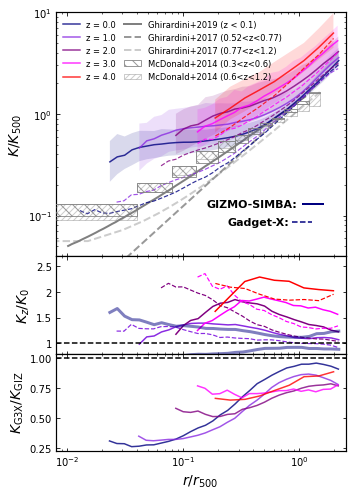

In [8]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
# colall = ['navy','purple','magenta','r','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
idtGIZ = [37,31,26,21,9,7,7]
idtG3X = [37,33,27,21,8,8,9]
#==========================================================

for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x, np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x, np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
    
    
ax1.text(0.16,1.2e-1,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.24,0.8e-1,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.84,0.175))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.8,0.10))
ax1.add_artist(legend0)

ob_Entropy(ax1)
#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$K/K_{500}$',fontsize = 14)
ax1.loglog()
ax1.legend(fontsize = 'small', ncol = 2, loc = 2, frameon = False, columnspacing = 1)
ax1.set_xticklabels([])
ax1.set_ylim(4e-2,1e1)
ax1.set_xlim(0.008,2.5)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
ax10.set_xlabel(r'$r/r_{500}$',fontsize = 14)
ax10.set_ylabel(r'$K_z/K_0$',fontsize = 14)

ax10.set_ylim(0.8,2.7)
ax10.set_yticks([1,1.5,2,2.5])
ax10.set_yticklabels([1,1.5,2,2.5])

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
# ax20.set_ylim(0.4,1.35)
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$K_{\rm G3X}/K_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
plt.savefig('./figsv2/Entropy.pdf')

In [4]:
def ob_Entropy():
    #Ghirardini+2021_X-COP sample
    G2021 = np.loadtxt(open('./data/ob_Entropy/Ghirardini+2021_X-COP.csv', 'r'),delimiter = ',')
    plt.plot(G2021[:,0], G2021[:,1], ls = '--', c = 'orange', lw = 2, label = 'Ghirardini+2018 (z < 0.1)')
    
    #--------------------------
    #Ghirardini+2017
    def fitfunc(xx, k0, k015, alpha):
        return k0 + k015*xx**alpha
    xx = np.linspace(0,10,100)
    # 0.4 < z < 0.52
    yy = fitfunc(xx, 0, 0.188, 1.04)
    plt.plot(xx*0.15,yy, ls = '--', c = 'magenta',lw = 2,
             label = 'Ghirardini+2017 (0.4<z<0.52)')
    
#     # 0.52 < z < 0.77
#     yy = fitfunc(xx, 0, 0.189, 1.04)
#     plt.plot(xx*0.15,yy, ls = '--', c = 'purple',lw = 2,
#              label = 'Ghirardini+2017 (0.52<z<0.77)')
    
    # 0.77 < z < 1.2
    yy = fitfunc(xx, 0.04, 0.16, 1.0)
    plt.plot(xx*0.15,yy, ls = '--', c = 'cyan',lw = 2,
             label = 'Ghirardini+2017 (0.77<z<1.2)')
    #--------------------------
    #McDonald+2014
    xx = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    xxm = (xx[1:] + xx[:-1])/2
    xxl = xxm - xx[:-1]
    xxr = xx[1:] - xxm
    # 0.3 < z < 0.6
    y1 = np.array([0.13,0.20,0.26,0.35,0.44,0.55,0.67,0.81,0.95,1.17,1.48,1.78])
    y1errup = np.array([0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.05,0.07,0.11,0.22])
    y1errdown = np.array([0.03,0.03,0.02,0.02,0.02,0.03,0.03,0.03,0.05,0.05,0.14,0.14])
    plt.errorbar(xxm, y1, xerr = [xxl, xxr], yerr = [y1errdown, y1errup],
                 fmt = 'none', lw =2,label = 'McDonald+2014 (0.3<z<0.6)')
    # 0.6 < z < 1.2
    y2 = np.array([0.11,0.19,0.28,0.39,0.49,0.60,0.69,0.79,0.87,1.00,1.14,1.37])
    y2errup = np.array([0.02,0.02,0.03,0.04,0.05,0.02,0.03,0.03,0.04,0.05,0.12,0.22])
    y2errdown = np.array([0.02,0.02,0.03,0.03,0.03,0.04,0.02,0.03,0.03,0.05,0.08,0.16])
    plt.errorbar(xxm, y2, xerr = [xxl, xxr], yerr = [y2errdown, y2errup],
                 fmt = 'none', lw =2,label = 'McDonald+2014 (0.6<z<1.2)')
    
plt.figure()

ob_Entropy()

plt.xlabel(r'$r/r_{500}$')
# plt.ylabel(r'$K[keV\ cm^2]$')
plt.ylabel(r'$K/K_{500}$')
plt.loglog()
plt.legend()
# plt.ylim(1e1,1e3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<IPython.core.display.Javascript object>


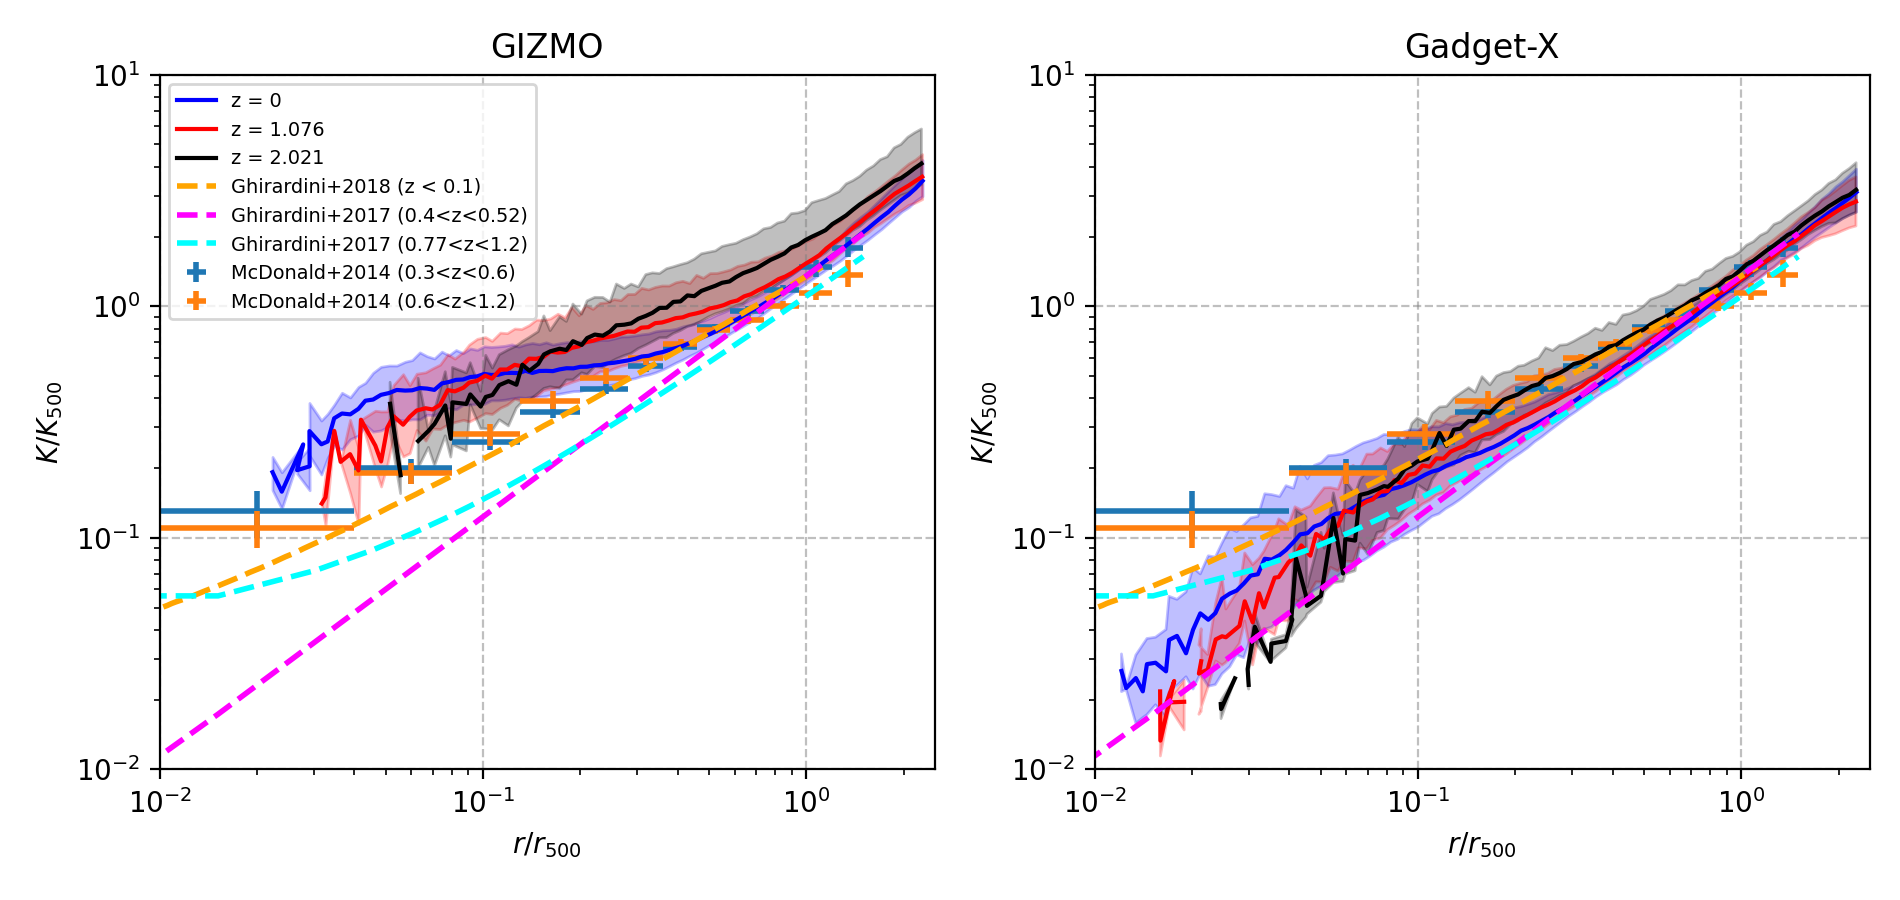

324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [92]:
#Entropy

plt.figure(figsize = (9.5,4.5))

plt.subplot(121)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Entropy',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Entropy',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Entropy',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Entropy()

plt.title('GIZMO')
plt.xlabel(r'$r/r_{500}$')
# plt.ylabel(r'$K[keV\ cm^2]$')
plt.ylabel(r'$K/K_{500}$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(1e-2,1e1)
plt.xlim(1e-2,2.5)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'Entropy',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'Entropy',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'Entropy',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

plt.title('Gadget-X')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$K/K_{500}$')
# plt.ylabel(r'$K[keV\ cm^2]$')
plt.loglog() 
plt.ylim(1e-2,1e1)
plt.xlim(1e-2,2.5)
ob_Entropy()
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.tight_layout()

<IPython.core.display.Javascript object>


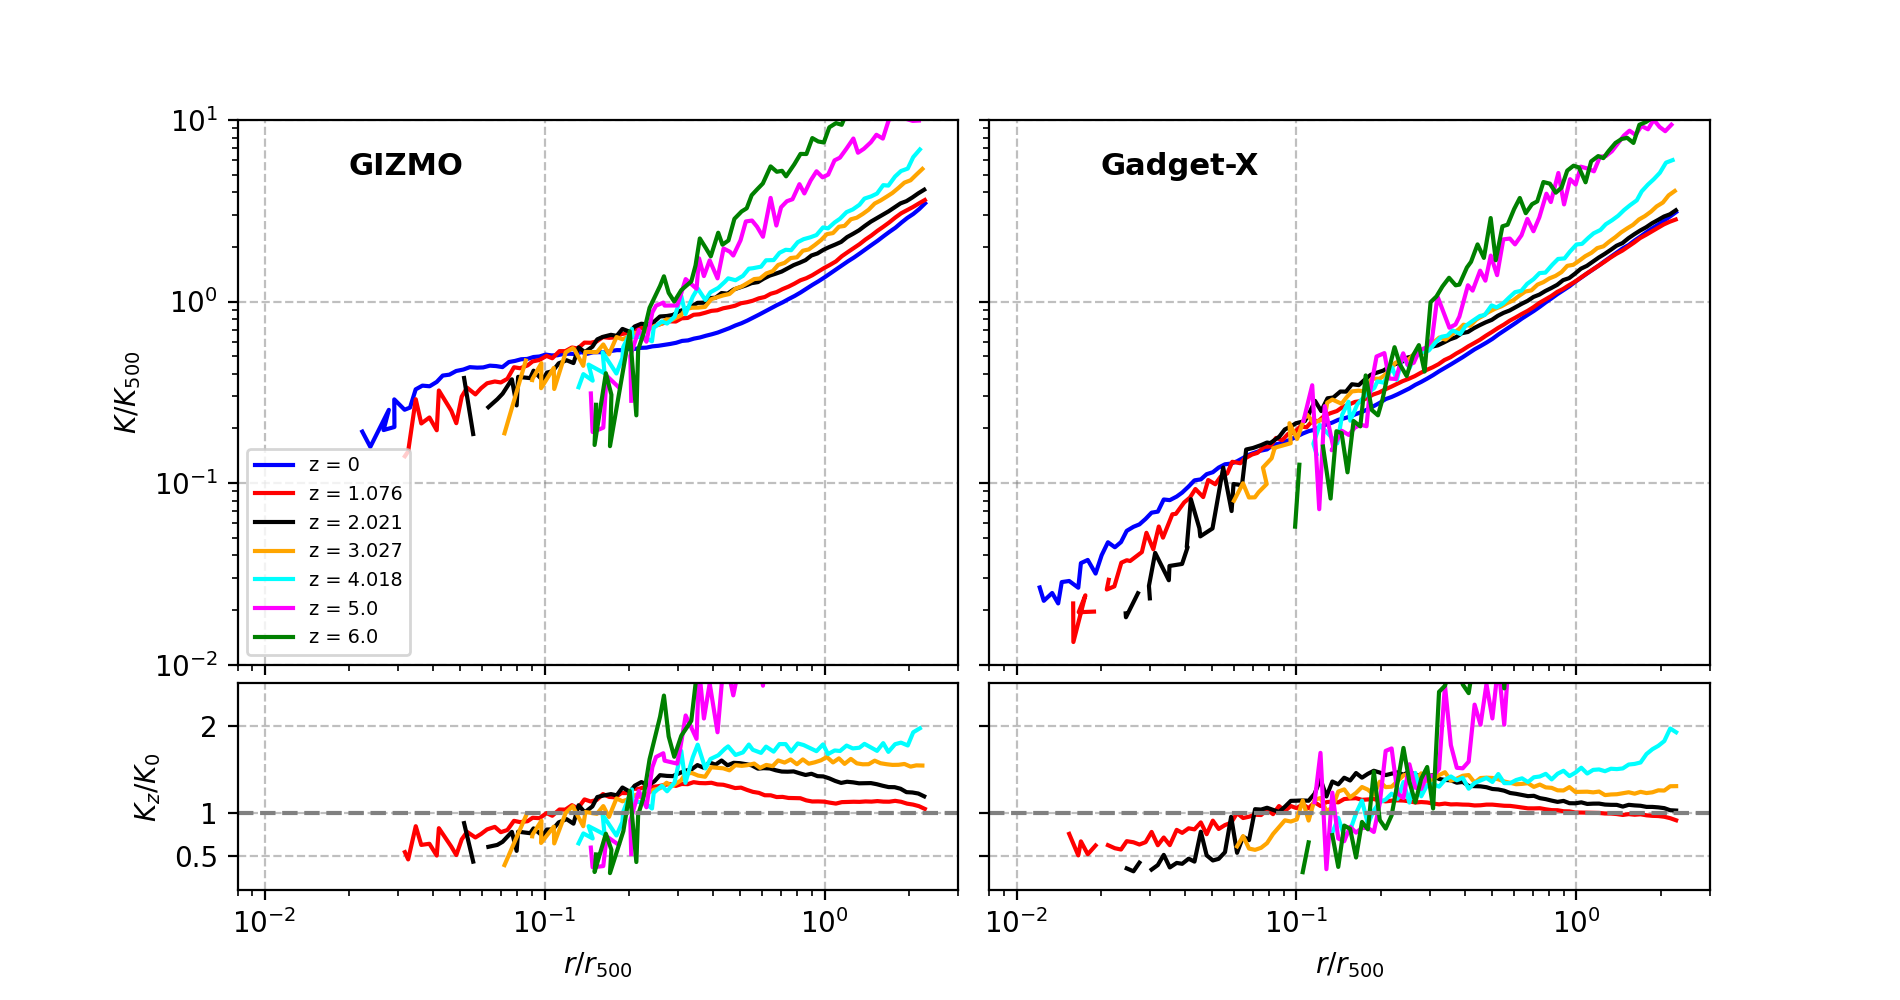

324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [10]:
#study evolution of gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','g']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Entropy',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(2e-2,5,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$K/K_{500}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.set_xticklabels([])
ax1.set_ylim(1e-2,1e1)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.1,2.5)
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$K_z/K_0$')
ax10.set_yticks([0.5,1,2])
ax10.set_yticklabels([0.5,1,2])

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Entropy',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(2e-2,5,'Gadget-X',weight = 'bold',size = 11)

ax2.loglog()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.set_ylim(1e-2,1e1)
ax2.set_xlim(0.008,3)

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.1,2.5)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,2])
ax20.set_yticklabels([])
# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

In [ ]:
# '''
# calculate median profiles and percentile error [16,84] statistically

# mod: simulation name [GIZMO or GadgetX]
# d: simulation data
# snap: which snapshot (equally redshift)
# region: which property
# ntclu: total cluster number (few clusters may not form at high redshift)
# part: which particle part (default 0, this is not meaning DM particles)
# '''

# def cal_sta_profiles(mod,d,snap,region,ntclu,part = 0):
#     nbin = 150
#     allvalue=np.zeros(shape = (ntclu,nbin))
#     rbinvalue=np.zeros(shape = (ntclu,nbin))
#     npvalue=np.zeros(shape = (ntclu,nbin))
    
#     redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
#     Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
#     fb = 0.15
#     mu = 0.5994
#     mue = 1.1548
    
#     i = 0
    
#     for nclu in range(324):
#         if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
#             continue
#         M500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
#         T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This 
#         r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
#         rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500

#         #Voit+2005 from Ghirardini+2021
#         K500 = 1667 * (M500/(1e15*0.7))**(2/3)*Ez**(-2/3)*(fb/0.16)**(-2/3)*(mu/0.6)*(mue/1.14)**(2/3)
        
#         region = 'Entropy'
#         temp = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
#         region = 'Eledens'
#         eletron = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
#         eletron = eletron * 0.6777**3 * (1+redshift)**3 * 0.6777
        
#         allvalue[i] = temp*eletron**(-2/3) / K500
#         npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]
#         i+=1

# #         combine bins which particles less than 50
#     for i in range(ntclu):
#         nset = 0
#         nskip = 0
#         binid = []
#         for j in range(nbin):
#             nset += npvalue[i,j]
#             binid.extend([j])
#             nskip += 1
#             if nskip == 1 and nset >= 50:
#                 nset = 0
#                 nskip = 0
#                 binid = []
#             elif nskip > 1 and nset >= 50:
#                 # numbner weighted values
#                 allvalue[i,j] = np.sum(npvalue[i,binid] * allvalue[i,binid]) / np.sum(npvalue[i,binid])
#                 # numbner weighted rbins
#                 rbinvalue[i,j] = np.sum(npvalue[i,binid] * rbinvalue[i,binid]) / np.sum(npvalue[i,binid]) 
                
#                 allvalue[i,binid[:-1]] = 0
#                 nset = 0
#                 nskip = 0
#                 binid = []
#             else:
#                 continue
                
#     #calculate the median profile
#     xmed = np.zeros(nbin)
#     ymed = np.zeros(nbin)
#     yerr = np.zeros(shape = (2,nbin))
#     bin0 = np.zeros(nbin)
#     for j in range(nbin):
#         nonan = np.where((allvalue[:,j]!= 0) & (np.isnan(allvalue[:,j]) == False))[0]
#         ymed[j] = np.median(allvalue[nonan,j])
#         xmed[j] = np.median(rbinvalue[nonan,j])
#         if len(nonan):
#             yerrtot = np.percentile(allvalue[nonan,j],[16,84])
#             yerr[0,j] = yerrtot[0]
#             yerr[1,j] = yerrtot[1]
#         bin0[j] = nonan.shape[0]
#     print(ymed)
#     return xmed,ymed,yerr

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: tight_layout() got an unexpected keyword argument 'wspace'